# AI Labor HSKA: Reinforcement Learning

## Wiederholung: Q-Learning

Q-Learning basiert auf Temporalen Differenz (TD)-Lernen (engl. Temporal Difference Learning). Die Idee von TD Methoden ist es, die bisherige Schätzung der Value-Function zusammen mit dem unmittelbar erhaltenen Reward nach Ausführung einer Aktion zu nutzen, um die bisherige Schätzung der Value-Function zu aktualisieren. Diese Aktualisierung findet nach jeder Aktionswahl statt. Im einfachsten Fall wählt der Agent eine Aktion anhand seiner Policy, erhält eine Belohnung und passt die Value-Function wie folgt an:

$$V(s_t) \leftarrow V(s_t) + \alpha [\overbrace{\underbrace{R_t + \gamma V(s_{t+1})}_{target} - V(s_t)}^{TD\ error}]$$

Daraus ergibt sich die Lernregel für das Q-Learning:

$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha\left[R(s_t,a_t)+\gamma \max_{a\in A(s_{t+1})} Q(s_{t+1},a) - 
Q(s_t,a_t)\right]$$

$Q$ approximiert dabei $q^*$ und damit die optimale Action-Value Function. Ist $q^*$ bekannt, können optimale Aktionen ohne jegliches Wissen über Nachfolgezustände (Successor States) oder deren Werte gewählt werden, da bereits die zu wählende Aktion für einen Zustand gegeben ist. Das heißt, der agent muss nichts über die Dynamik (Transition Model, Reward Function) der Umgebung wissen.

## Aufgabe 1

Vervollständige die in **agent.py** vorgebene Implementierung eines Agent, der mit Hilfe von Q-Learning eine optimale Policy $\pi^*$ findet. Pro Episode sind maximal 200 Steps in den beiden Ausprägungen der GridWorld erlaubt, danach wird das Environment zurückgesetzt.

Der Agent soll über 50 Episoden hinweg versuchen eine optimale Policy zu finden.

In [8]:
%run ../setup.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
from lib import GridWorld
from lib.statistics import plot

n_episodes = 50
max_steps = 200
statistics = []

def interact_with_environment(env, agent, verbose=False):
    if verbose:
        print('Startposition:')
        env.render()
    
    for episode in range(n_episodes):
        done = False
        total_reward = 0
        state = env.reset()

        for t in range(max_steps):
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.train((state, action, next_state, reward, done))
            
            state = next_state
            total_reward += reward
            
            if done:
                break
        
        if verbose:
            print(f'episode: {episode}/{n_episodes}, score: {total_reward}, steps:{t}, e:{agent.epsilon:.2f}')
            env.render()
            
        statistics.append({
            'episode': episode,
            'score': total_reward,
            'steps': t
        })
        
    return statistics

### Aufgabe 1.1

Der Agent soll folgende Ausprägung der GridWorld lösen: Die Start- und Zielposition des Agenten ist fest vorgegeben und ändert sich nicht. Das Transition Model dieser GridWorld ist deterministisch (`transition_probability=1.0`). D.h. die vom Agenten gewählte Aktion wird in jedem Fall ausgeführt.

In [160]:
env = GridWorld(env_x=8, env_y=8, init_agent_pos=(0,0), goal_pos=(7,7), max_steps=max_steps, transition_probability=1.0)

In [144]:
from agent import QLearning
import numpy as np
import random

In [145]:
## Assertions, please do not change
np.random.seed(42)
test_agent = QLearning(action_dim=(2,), state_dim=(2,2), gamma=5, epsilon=0.8, alpha=2)
assert test_agent.Q.shape == (2,2,2,2,2), 'Q shape incorrect. Please check agent init method'
test_agent.Q = np.array([[[[[.5, 0.],[0., 0.]],[[0., 0.],[0., 0.]]],[[[0., 0.],[0., 0.]],[[0., 0.],[0.,0.]]]],[[[[0., 0.],[0., 0.]],[[0., 0.],[0., 0.]]],[[[0., 0.],[0., 0.]],[[0., 0.],[.1, .2]]]]])
action = test_agent.act((1,1,1,1))
assert action == 0, 'Agent should explore the environment. Please check agent act method'
action = test_agent.act((1,1,1,1))
assert action == 1, 'Agent should exploit the environment. Please check agent act method'
test_agent.train(((1,1,1,1),1,(0,0,0,0),5,False))
assert np.allclose(test_agent.Q, np.array([[[[[.5, 0.],[0., 0.]],[[0., 0.],[0., 0.]]],[[[0., 0.],[0., 0.]],[[0., 0.],[0.,0.]]]],[[[[0., 0.],[0., 0.]],[[0., 0.],[0., 0.]]],[[[0., 0.],[0., 0.]],[[0., 0.],[.1, 14.8]]]]])), 'Q update incorrect. Please check agent train method'

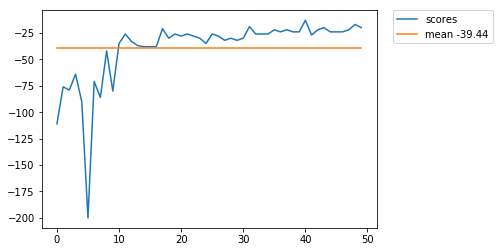

[{'episode': 0, 'score': -111, 'steps': 111}, {'episode': 1, 'score': -76, 'steps': 76}, {'episode': 2, 'score': -79, 'steps': 79}, {'episode': 3, 'score': -64, 'steps': 64}, {'episode': 4, 'score': -90, 'steps': 90}, {'episode': 5, 'score': -200, 'steps': 199}, {'episode': 6, 'score': -71, 'steps': 71}, {'episode': 7, 'score': -86, 'steps': 86}, {'episode': 8, 'score': -42, 'steps': 42}, {'episode': 9, 'score': -80, 'steps': 80}, {'episode': 10, 'score': -35, 'steps': 35}, {'episode': 11, 'score': -26, 'steps': 26}, {'episode': 12, 'score': -33, 'steps': 33}, {'episode': 13, 'score': -37, 'steps': 37}, {'episode': 14, 'score': -38, 'steps': 38}, {'episode': 15, 'score': -38, 'steps': 38}, {'episode': 16, 'score': -38, 'steps': 38}, {'episode': 17, 'score': -21, 'steps': 21}, {'episode': 18, 'score': -30, 'steps': 30}, {'episode': 19, 'score': -26, 'steps': 26}, {'episode': 20, 'score': -28, 'steps': 28}, {'episode': 21, 'score': -26, 'steps': 26}, {'episode': 22, 'score': -28, 'steps'

In [164]:
statistics = []
# Hyperparams
gamma = 0.75
epsilon = 0.001
epsilon_decay = 0.9
epsilon_min = 0.0001
alpha = 1.0
alpha_decay = 0.999
alpha_min = 0.001

agent = QLearning(action_dim=env.action_dim, state_dim=env.state_dim,
                  gamma=gamma, epsilon=epsilon, alpha=alpha)

statistics = interact_with_environment(env, agent, verbose=False)
plot(statistics)
print(statistics)

### Aufgabe 1.2

Erweitere (falls nötig) die Implementierung deines Agenten, sodass er die RandomGridWorld (`transition_probability=0.8`) löst.

In [153]:
env = GridWorld(env_x=8, env_y=8, init_agent_pos=None, goal_pos=None, max_steps=max_steps, transition_probability=0.8)

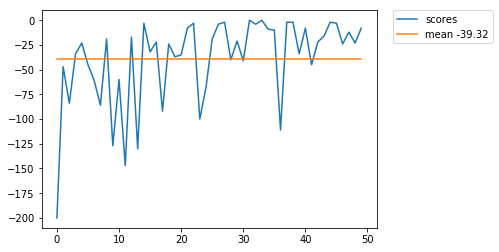

In [159]:
from agent import QLearning
statistics = []
# Hyperparams
gamma = 0.75
epsilon = 0.001
epsilon_decay = 0.9
epsilon_min = 0.0001
alpha = 0.9
alpha_decay = 0.999
alpha_min = 0.001

agent = QLearning(action_dim=env.action_dim, state_dim=env.state_dim,
                  gamma=gamma, epsilon=epsilon, alpha=alpha)

statistics = interact_with_environment(env, agent, verbose=False)
plot(statistics)

## Aufgabe 2
Beschreibe was eine optimale Policy ausmacht und begründe warum es mehrere optimale Policies gibt.